In [2]:
%matplotlib inline
from scipy.stats import rv_continuous
from scipy.special import gamma
import numpy as np
import emcee
from numpy import exp, sqrt
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
import hast
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
#import cfalcon
#CF =cfalcon.CFalcon()

# Load data

In [3]:
path = "/data/Andorra3Lowres/output_00041"
myhalo = wkbl.Galaxy_Hound(path,"halo,gas,stars")

loading Dark matter..
loading Gas..
loading Stars..


In [3]:
myhalo.r_virial(600)

SystemExit: ERROR in tree

# Define functions

In [ ]:
def myGaussian(x,mu,v0):
    alpha = 1.
    n = 2 * v0 * gamma(1+(1/(2*alpha)))
    return (1/n) * np.exp(-((x-mu)**2/(v0**2))**alpha)

def myDoubleGaussianFunc(x,frac,v01,mu2,v02):
    return frac*myGaussian(x,mu2,v01)+(1-frac)*myGaussian(x,0,v02)

def myGenMaxwellian(x,v0,alpha):
    n = v0**3 * gamma(1. + (3./(2.*alpha))) / 3.
    return (x**2/n) * np.exp(-(x/v0)**(2*alpha))

def myMaxwellian(x,v0):
    alpha = 1.
    n = v0**3 * gamma(1. + (3./(2.*alpha))) / 3.
    return (x**2/n) * np.exp(-(x/v0)**(2*alpha))

def abg_profile(x,p_s,r_s,al,be,ga):
    power =  (be - ga) / al
    denominator = ((x/r_s)**ga) * (1 + (x / r_s)**al)**power
    return p_s / denominator



# Get hist from $v_{\phi}$ in the shell

In [ ]:
# get v_phi of shell particles
shell_condition = (myhalo.dm.R< 7.)&(myhalo.dm.R< 9.)&(abs(myhalo.dm.pos3d[:,2])<4)
v_phi_shell = myhalo.dm.vphi[shell_condition]
# get hist
bin_num = 20
bins = np.linspace(v_phi_shell.min(),v_phi_shell.max(), bin_num)
v_phi_hist = np.histogram(v_phi_shell,bins=bins,normed=1)

# Double Gaussian fit:

In [ ]:
fitDG = wkbl.DG_fit()
params,chi2 = fitDG.bestfit(v_phi_hist[1][:-1],v_phi_hist[0])
print "fraction =  {0}\nw_free   =  {1}\nc_free   = {2}\nw_0      = {3}".format(params[0],params[1],params[2],params[3])
print "chi2     =", chi2

In [ ]:
fig, ax = plt.subplots()
w = (v_phi_shell.max()-v_phi_shell.min()) / bin_num
ax.bar(v_phi_hist[1][:-1]-w/2.,v_phi_hist[0],width=w)

ax.plot(v_phi_hist[1][:-1],
        myDoubleGaussianFunc(v_phi_hist[1][:-1],params[0]
                             ,params[1],params[2],params[3]),
        linewidth=2)
#ax.plot(v_phi_hist[1][:-1],myGaussian(v_phi_hist[1][:-1],20,350),linewidth = 2, c='k')

ax.plot(v_phi_hist[1][:-1],params[0]*myGaussian(v_phi_hist[1][:-1],params[2],params[1]),linewidth = 2)
ax.plot(v_phi_hist[1][:-1],(1-params[0])*myGaussian(v_phi_hist[1][:-1],0,params[3]),linewidth = 2)


# Single Gaussian Fit

In [ ]:
bin_num = 20
bins = np.linspace(v_phi_shell.min(),v_phi_shell.max(), bin_num)
v_phi_hist = np.histogram(v_phi_shell,bins=bins,normed=1)


fitDG = wkbl.SG_fit()

params,chi2 = fitDG.bestfit(v_phi_hist[1][:-1],v_phi_hist[0])


print "center =  {0} \nwidth   =  {1}".format(params[0],params[1])
print "chi2     =", chi2

In [ ]:
fig, ax = plt.subplots()
w = (v_phi_shell.max()-v_phi_shell.min()) / bin_num
ax.bar(v_phi_hist[1][:-1]-w/2,v_phi_hist[0],width=w)

ax.plot(v_phi_hist[1][:-1],myGaussian(v_phi_hist[1][:-1],params[0],params[1]), c = 'k', linewidth = 2)


# Get hist from $|\vec{v}|$ in shell 

In [ ]:
shell_condition = (myhalo.dm.r< 7.)&(myhalo.dm.r< 9.)
v_mod_shell = myhalo.dm.v[shell_condition]
bin_num = 60
bins = np.linspace(v_mod_shell.min(),v_mod_shell.max(), bin_num)
v_mod_hist = np.histogram(v_mod_shell,bins=bins,normed=1)

# General Maxwellian fit

In [ ]:

fitDG = wkbl.GM_fit()

params,chi2 = fitDG.bestfit(v_mod_hist[1][:-1],v_mod_hist[0])


print "width =  {0} \nalpha   =  {1}".format(params[0],params[1])
print "chi2     =", chi2

In [ ]:
fig, ax = plt.subplots()
w = (v_mod_shell.max()-v_mod_shell.min()) / bin_num
ax.bar(v_mod_hist[1][:-1]-w/2.,v_mod_hist[0],width=w)
ax.plot(v_mod_hist[1][:-1],myGenMaxwellian(v_mod_hist[1][:-1],params[0],params[1]), c = 'k', linewidth = 2)


# Mass Profile fit

In [ ]:
centroid = nbe.real_center(myhalo.dm.pos3d,myhalo.dm.mass)
myhalo.center_shift(centroid)
print centroid
r_profile , profile = myhalo.dm.density_profile(60, myhalo.r200)

In [ ]:
fitabg = wkbl.al_be_ga_fit()
params,chi2 = fitabg.bestfit(r_profile,profile)
texto = "rho_0     =  {0}\nr_s       =  {1}\nalpha     =  {2}\nbeta      =  {3}\ngamma     =  {4} \nchi2      = {5}".format(params[0],params[1], 
                                                                                                                            params[2],params[3],params[4],chi2)

print texto

In [ ]:
fig , ax = plt.subplots()
ax.plot(np.log10(r_profile),np.log10(profile),'b*-', label="data")
ax.plot(np.log10(r_profile),
        np.log10(abg_profile(r_profile,params[0],params[1],
                             params[2],params[3],params[4])),
        'k--', label="fit")
legend = ax.legend(loc='upper right', ncol=1, shadow=False,
                   
                    fontsize=17)
ax.text(-0.2,5,texto)

In [6]:

r_p = np.logspace(-0.5, np.log10(200),60)
dens = np.array([])
for i in range(len(r_p)-1):
    mass = np.sum(myhalo.dm.mass[(myhalo.dm.r > r_p[i])&(myhalo.dm.r > r_p[i+1])])
    volume = 4.* np.pi * (r_p[i+1]**3 - r_p[i]**3) / 3.
    dens = np.append(dens,mass/volume)
    

## R_p03 as in shellers thesis

In [10]:
Pcrit = myhalo.dm._p.rho_crit
Mdm = myhalo.dm.mass.min()
myradiuses = myhalo.dm.r[np.argsort(myhalo.dm.r)]
tabN = np.cumsum(np.ones(len(myradiuses)))[1:]
myradiuses = myradiuses[1:]
Rp03 = np.sqrt(200/64.) * np.sqrt(4 * np.pi * Pcrit * tabN / 3. / Mdm ) * (myradiuses**1.5)/ np.log(tabN) 
val =0.6
R_P03 = myradiuses[ np.where(Rp03 > val) ][0]

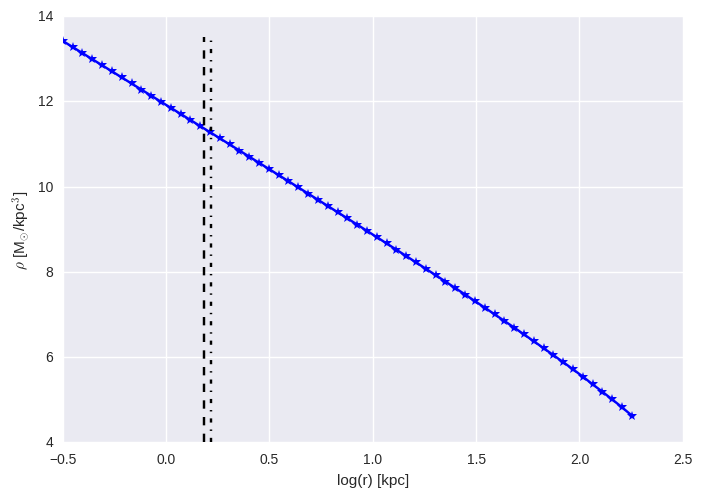

In [11]:
fig , ax = plt.subplots()
ax.plot(np.log10(r_p[0:-1]),np.log10(dens),'b*-', label="data")
ax.set_xlabel("log(r) [kpc]")
ax.set_ylabel(r'$\rho $ [M$_{\odot}$/kpc$^3$]')
y=[i for i in np.arange(4,14,0.5)]
x=[np.min(myhalo.gs.hsml) for i in range(len(y))]
x_P03=[np.min(R_P03) for i in range(len(y))]
ax.plot(np.log10(x_P03),y,'k-.')

ax.plot(np.log10(x),y,'k--')


In [ ]:
val = .6
print "R_P03 = {0} kpc".format(myradiuses[ np.where(Rp03 > val) ][0])